# Task - 3

In [65]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [66]:
if os.path.exists('bird.jpg'):
    print('bird.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O bird.jpg

bird.jpg exists


In [67]:
# Read in a image from torchvision
img = torchvision.io.read_image("bird.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


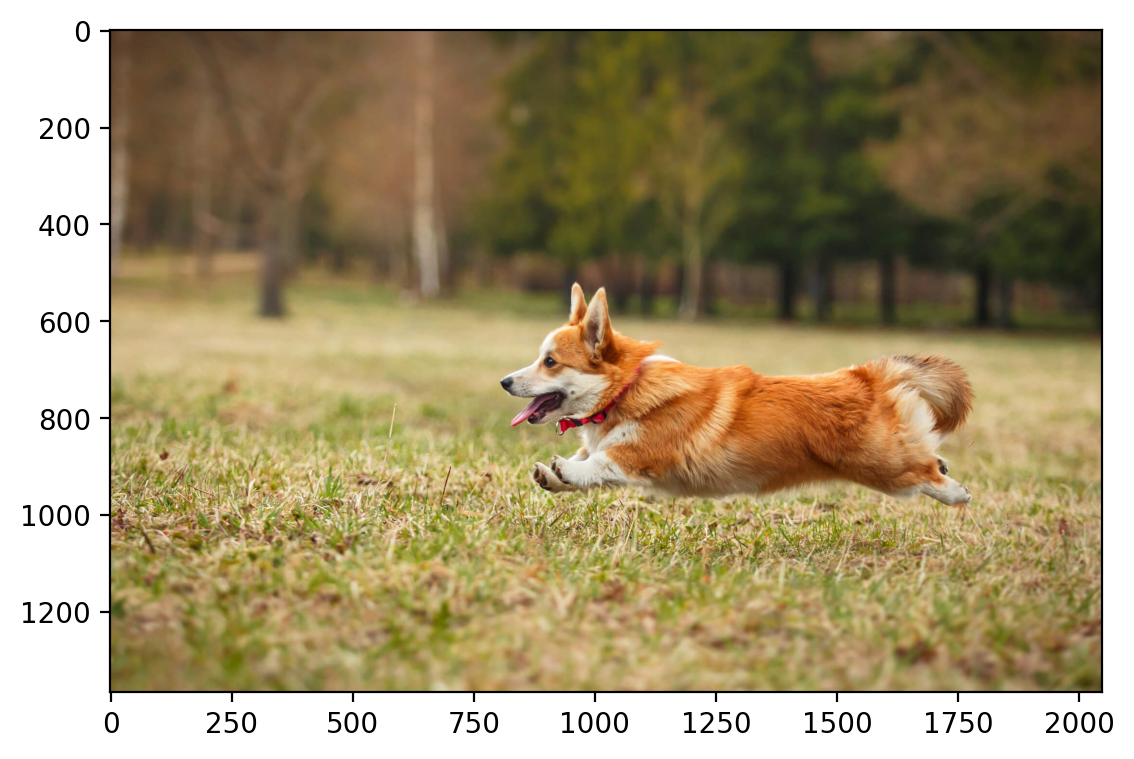

In [68]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [69]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [70]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [71]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
crop.shape

torch.Size([3, 400, 400])

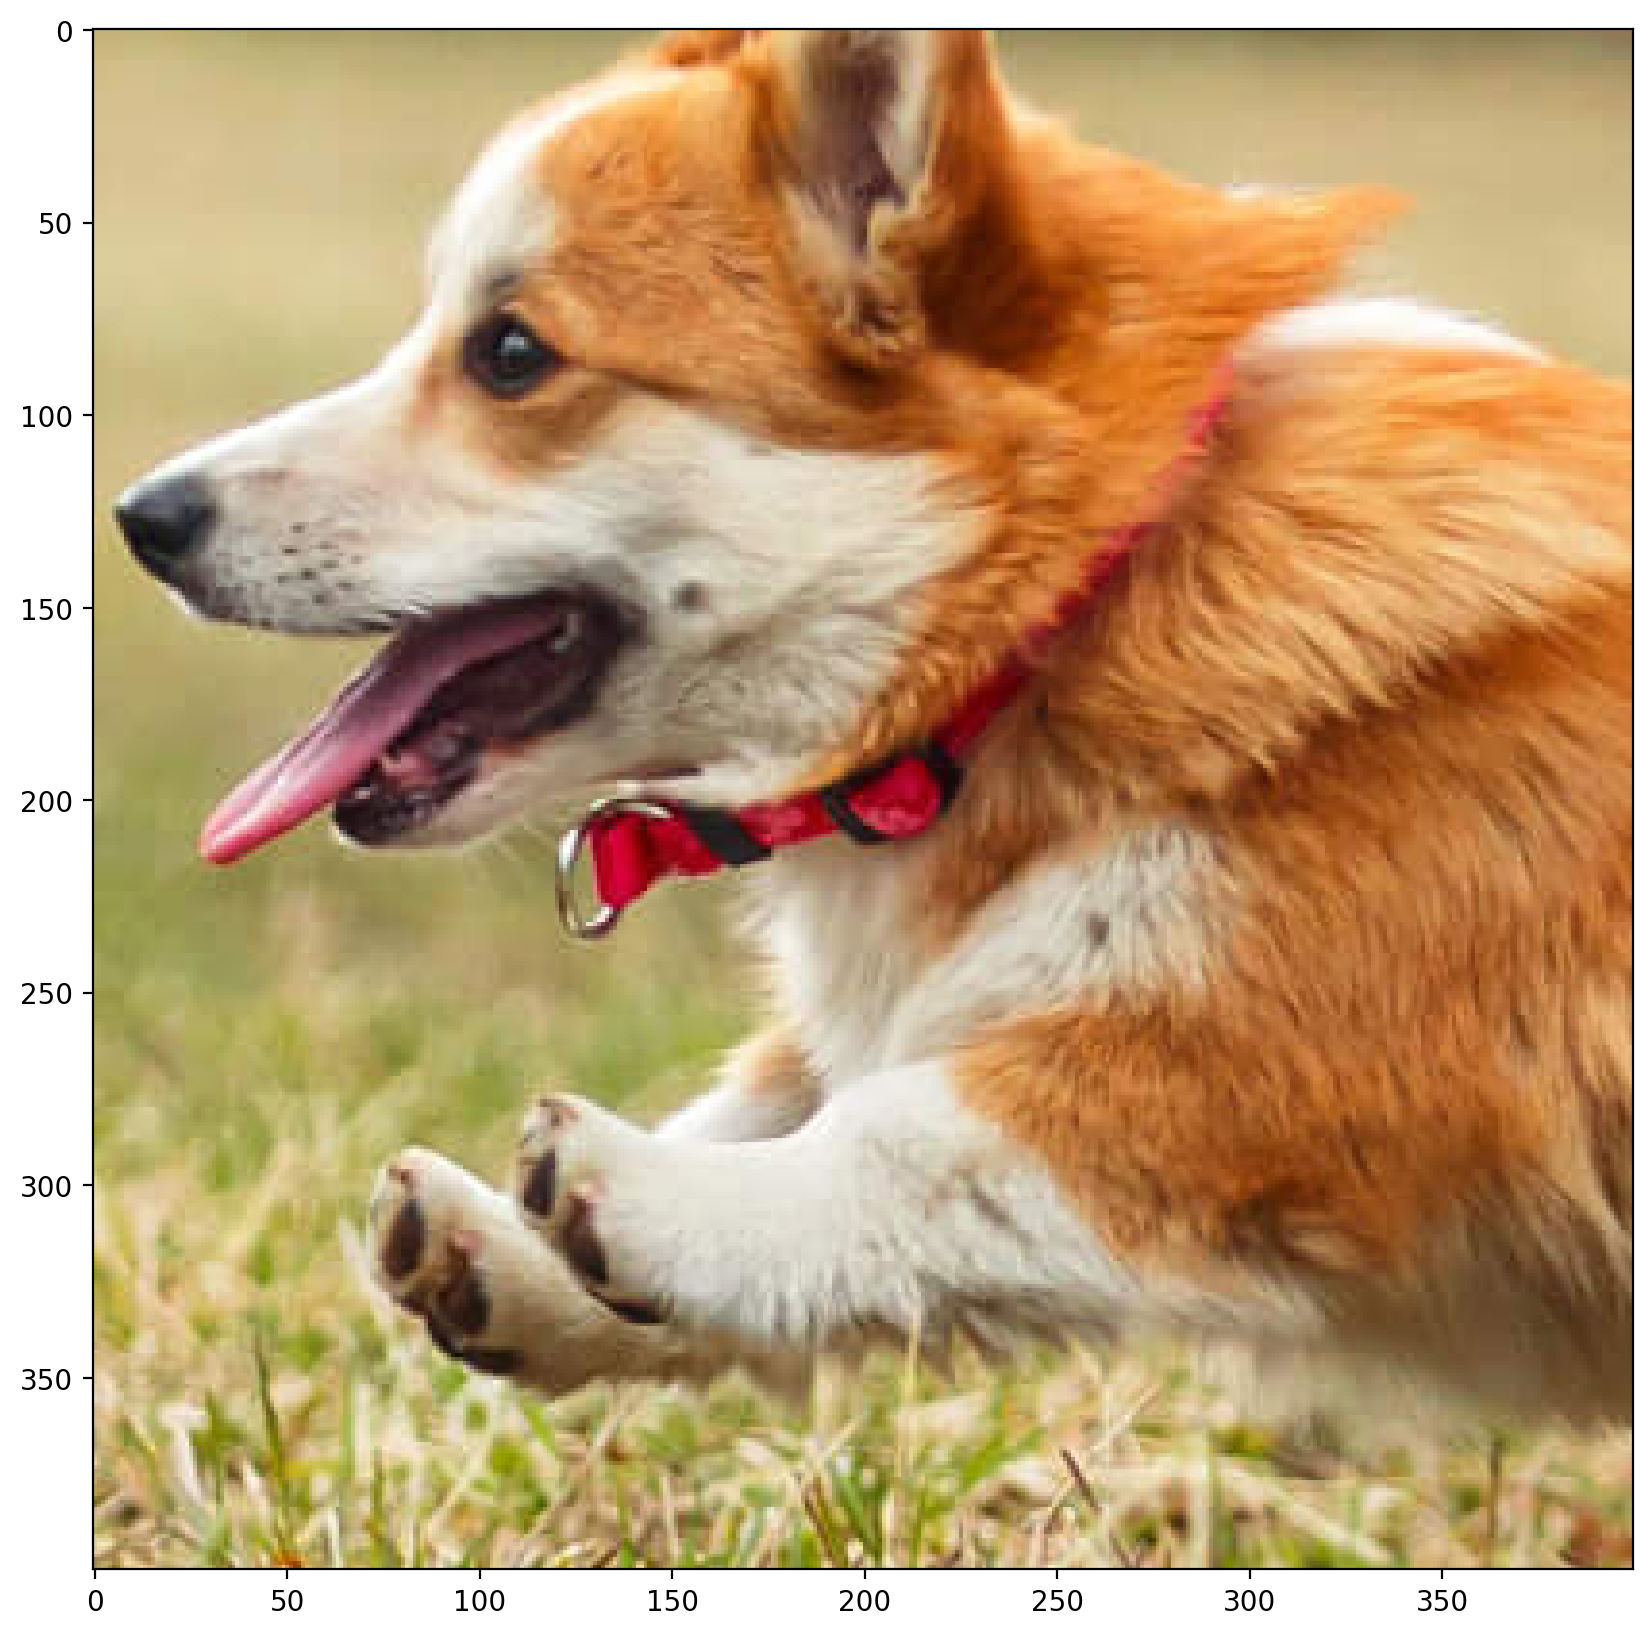

In [72]:
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [73]:
original_img = crop

In [74]:
import cv2

# Assuming 'crop' is a PyTorch tensor of shape [C, H, W]
# Convert the tensor to a NumPy array (convert to CPU and detach from the computational graph)
crop_numpy = crop.permute(1, 2, 0).cpu().numpy()  # Convert [C, H, W] -> [H, W, C] for OpenCV

# Resize using OpenCV
resized_crop = cv2.resize(crop_numpy, (200, 200))  # Resize to (width=200, height=200)

# If needed, convert the resized NumPy array back to a PyTorch tensor
resized_crop_tensor = torch.from_numpy(resized_crop).permute(2, 0, 1)  # Convert [H, W, C] -> [C, H, W]
crop=resized_crop_tensor

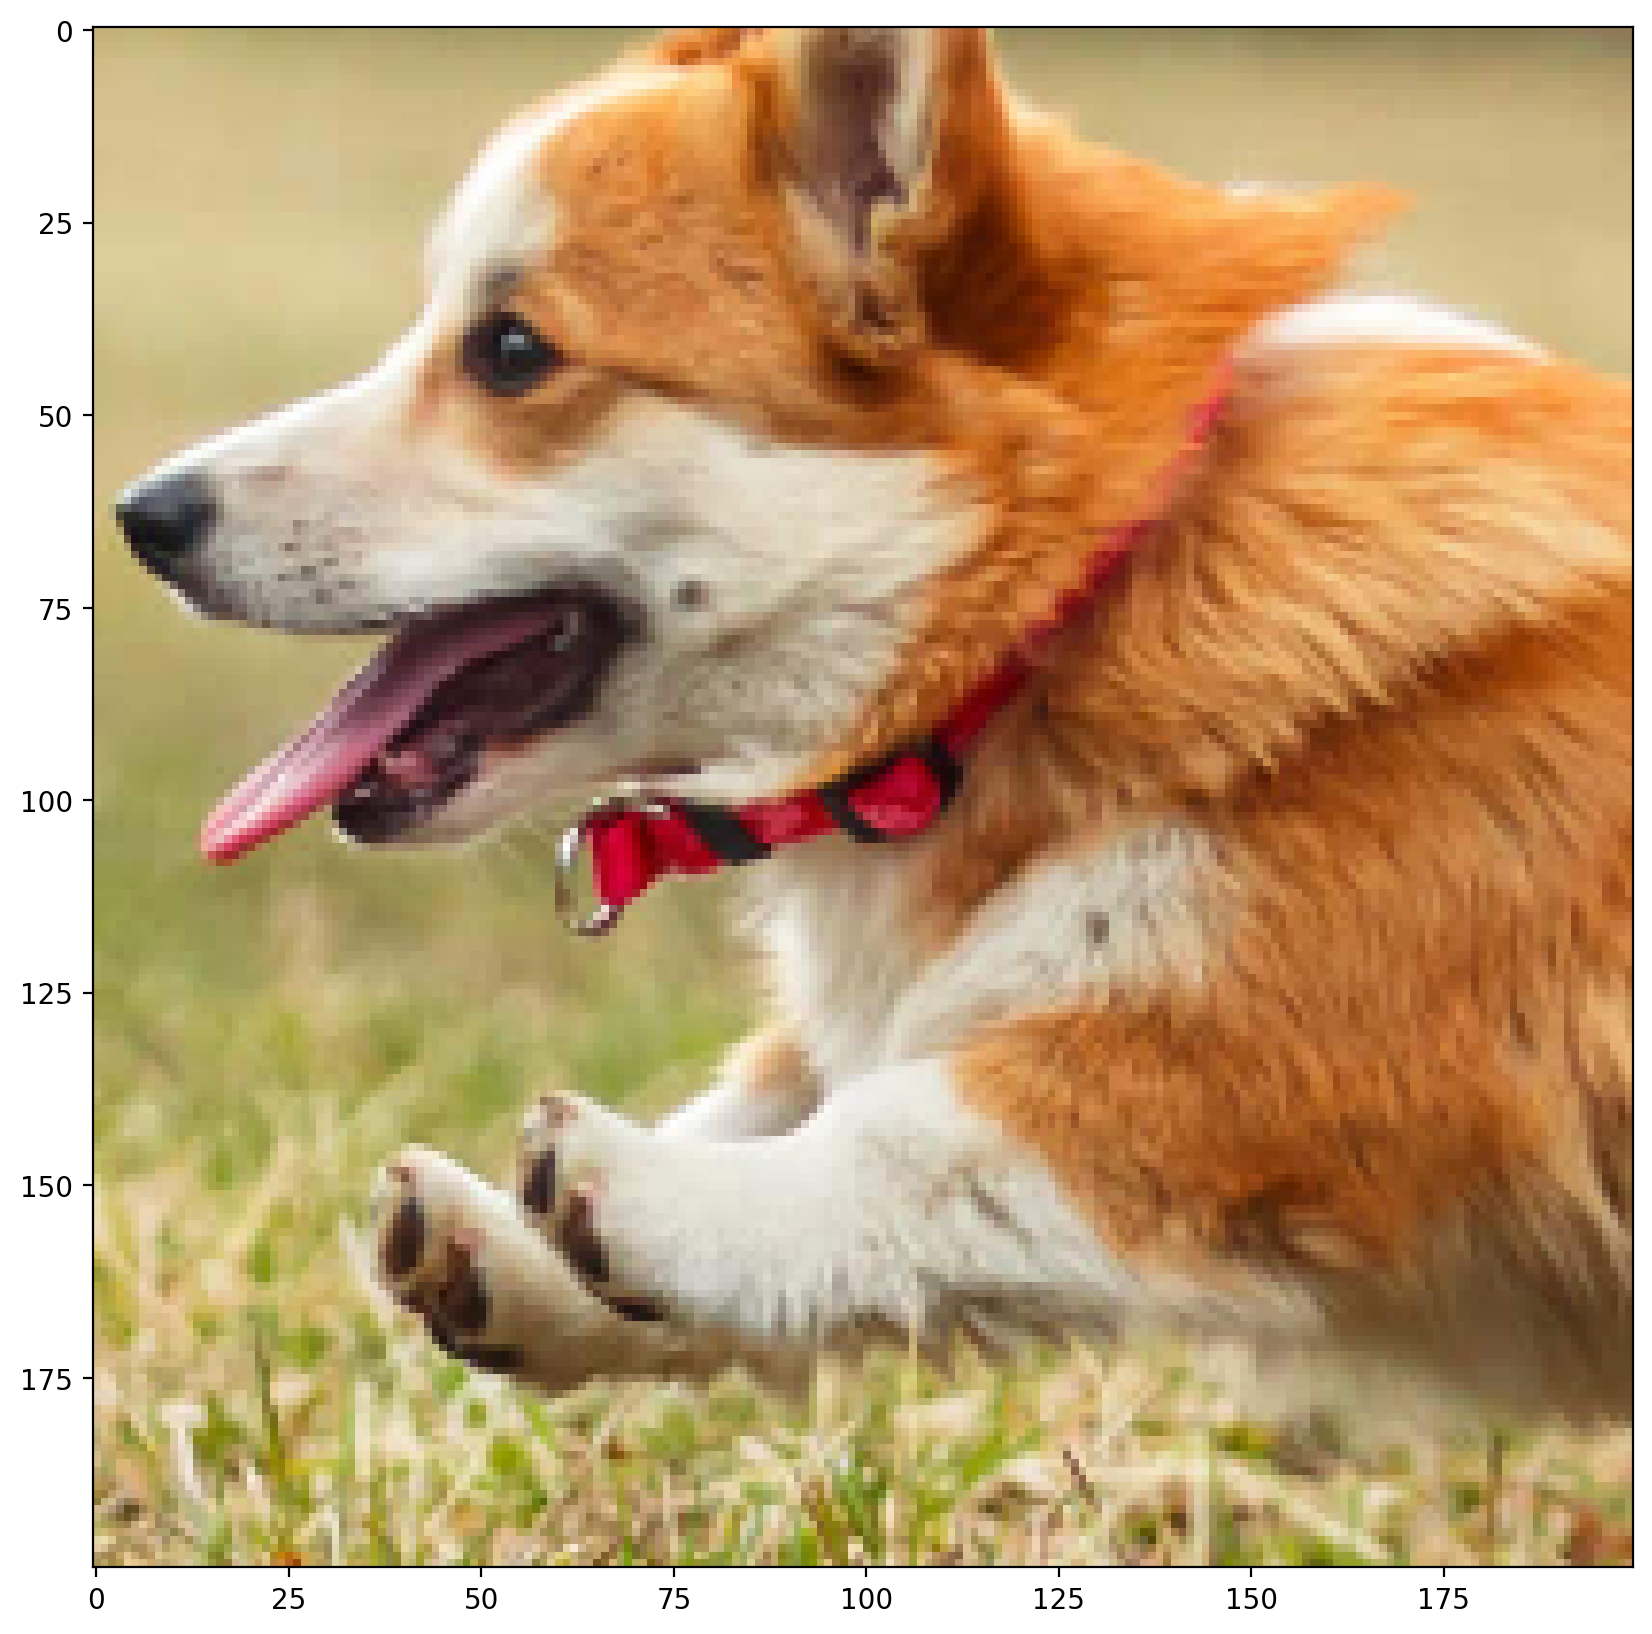

In [75]:
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [76]:
crop = crop.to(device)

In [77]:
def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    height *= scale
    width *= scale

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float().to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [78]:

dog_X, dog_Y = create_coordinate_map(crop)

dog_X.shape, dog_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [79]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).float().to(device)



In [80]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [81]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [82]:
num_features = 37500
sigma = 0.008

from sklearn.kernel_approximation import RBFSampler
rff = RBFSampler(n_components=num_features, gamma=1/(2*sigma**2), random_state=42)

In [83]:
# create RFF features
def create_rff_features(X, rff, num_features, sigma):
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [84]:
X_rff = create_rff_features(dog_X_scaled,rff, 37500, 0.008)

In [85]:
X_rff.shape

torch.Size([40000, 37500])

In [86]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [87]:
in_features = X_rff.shape[1]
out_features = 3
net = LinearModel(in_features,out_features).to(device)

train(net, 0.1, X_rff, dog_Y, 2500)

Epoch 0 loss: 0.365065
Epoch 100 loss: 0.000222
Epoch 200 loss: 0.000212
Epoch 300 loss: 0.000209
Epoch 400 loss: 0.000209
Epoch 500 loss: 0.000210
Epoch 600 loss: 0.000212
Epoch 700 loss: 0.000212
Epoch 800 loss: 0.000215
Epoch 900 loss: 0.000215
Epoch 1000 loss: 0.000220
Epoch 1100 loss: 0.000218
Epoch 1200 loss: 0.000222
Epoch 1300 loss: 0.000222
Epoch 1400 loss: 0.000219
Epoch 1500 loss: 0.000218
Epoch 1600 loss: 0.000219
Epoch 1700 loss: 0.000217
Epoch 1800 loss: 0.000223
Epoch 1900 loss: 0.000228
Epoch 2000 loss: 0.000221
Epoch 2100 loss: 0.000223
Epoch 2200 loss: 0.000221
Epoch 2300 loss: 0.000219
Epoch 2400 loss: 0.000222


0.00022452756820712239

In [88]:
crop.shape

torch.Size([3, 200, 200])

In [89]:
from sklearn.preprocessing import MinMaxScaler
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.inference_mode():
        outputs = net(X)
        print(outputs.shape)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    outputs=MinMaxScaler(feature_range=(0,1)).fit_transform(outputs.reshape(-1,1)).reshape(height,width,num_channels)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
#     ax0.imshow(outputs.cpu())
    ax0.imshow(outputs)

    ax0.set_title("Reconstructed Image")
    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    for a in [ax0, ax1]:
        a.axis("off")
    fig.suptitle(title, y=0.9)
    plt.tight_layout()

torch.Size([40000, 3])


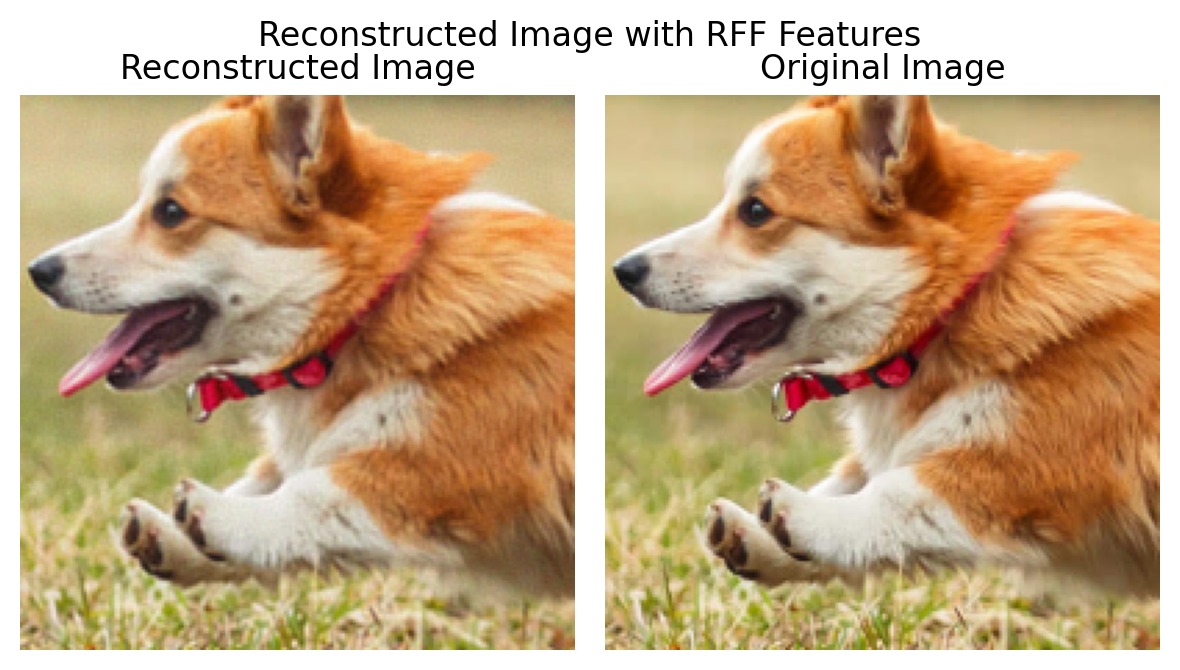

In [90]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

In [91]:
def create_high_res_grid(img, scale_factor):
    num_channels, height, width = img.shape
    new_height, new_width = height * scale_factor, width * scale_factor

    w_coords=torch.arange(0, width, 1/scale_factor).repeat(new_height, 1)

    h_coords=torch.arange(0, height, 1/scale_factor).repeat(new_width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float()

    X = X.to(device)
    Y=rearrange(img, 'c h w -> (h w) c').float()
    return X,Y

dog_X shape:  torch.Size([160000, 2])
torch.Size([160000, 37500])
torch.Size([3, 200, 200]) torch.Size([160000, 37500])
torch.Size([400, 400, 3])


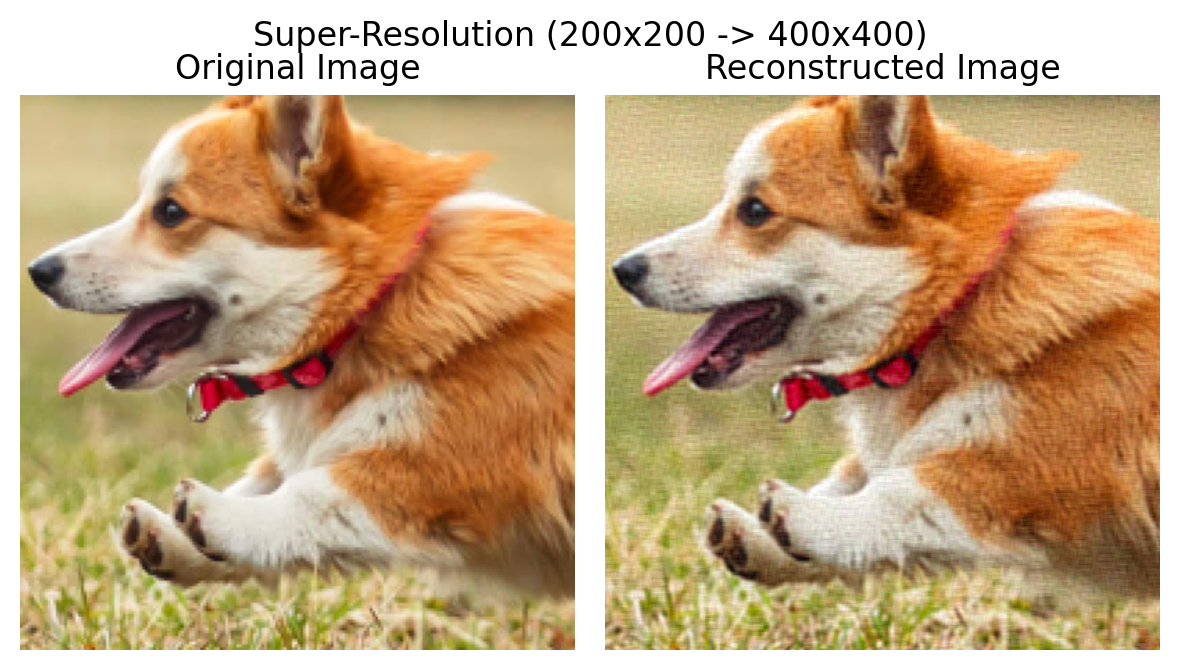

In [92]:
# Create high-resolution coordinates for the 400x400 image
dog_X , Y= create_high_res_grid(crop,2)
print("dog_X shape: ", dog_X.shape)
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())
# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()
# Create RFF features for high-resolution grid
X_rff_high_res = create_rff_features(dog_X_scaled,rff, num_features=40000, sigma=0.008)

print(X_rff_high_res.shape)

def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.inference_mode():
        outputs = net(X)

        outputs = outputs.reshape(height*2, width*2, num_channels)
        pred_img = outputs.to(device)
        print(pred_img.shape)
        pred_img = rearrange(pred_img, 'h w c -> c h w', h=400, w=400)

    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax1.imshow(outputs.cpu())
    ax1.set_title("Reconstructed Image")

    ax0.imshow(original_img.cpu().permute(1, 2, 0))
    ax0.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    return pred_img
print(crop.shape,X_rff_high_res.shape)
# Plot the results
Y=plot_reconstructed_and_original_image(crop,net,X_rff_high_res, title="Super-Resolution (200x200 -> 400x400)")

In [93]:
def calRMSE_and_PSNR(img1, img2):
    """
    img1: torch.Tensor of shape (num_channels, height, width)
    img2: torch.Tensor of shape (num_channels, height, width)

    return: tuple of float and float
    """
    device = img1.device
    img2 = img2.to(device)

    # Ensure both images have the same shape
    if img1.shape != img2.shape:
        raise ValueError(f"Shape mismatch: img1 has shape {img1.shape}, but img2 has shape {img2.shape}")

    # Normalize images if required (assuming values should be between 0 and 1)
    img1 = torch.clamp(img1, 0, 1)
    img2 = torch.clamp(img2, 0, 1)

    # Calculate RMSE
    rmse = torch.sqrt(torch.mean((img1 - img2) ** 2))

    # Calculate PSNR (assumes pixel values are in the range [0, 1])
    psnr = 20 * torch.log10(1.0 / (rmse + 1e-8))  # Add small value to avoid division by zero

    return rmse.item(), psnr.item()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
crop = crop.to(device)

rmse, psnr = calRMSE_and_PSNR(Y, original_img)

In [94]:
print("RMSE: ", rmse, "\nPSNR: ", psnr)

RMSE:  0.034708193202996895 
PSNR:  29.191357371758592
